# Leave-pair-out cross-validation

Notebook contains the final validation of an approach developed during previous experiments. Since the size of a dataset is small, LPOCV method is used to test solutions instead of a traditional test subset. This technique is found to be more reliable in the case of a small number of samples (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4108045/). Prediction results from all folds, as well as feature importances from all trained models, are aggregated, visualized, and saved to files.

In [1]:
import os
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory path to save results

In [3]:
output_dir = '../results/updated_data/all_features/PDAC/LPO_validation/binary_I-II_vs_III-IV/without_augmentation/'

Load dataset

In [4]:
data_path = '../data/cleaned/updated/all_features/PDAC/'

dataset = pd.read_csv(os.path.join(data_path, 'dataset.csv'), sep=';')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 5331 entries, ID to CASC15
dtypes: float64(5327), object(4)
memory usage: 5.1+ MB


Prepare data for validation

In [5]:
dataset_binary = dataset.copy(deep=True)

binary_mapping = {
    'I': 'I-II',
    'II': 'I-II',
    'III': 'III-IV',
    'IV': 'III-IV'
}
dataset_binary.loc[:, 'Stage'] = dataset_binary['Stage'].map(binary_mapping)
sample_ids = dataset_binary.loc[:, 'ID']
dataset_binary = dataset_binary.loc[:, ~dataset_binary.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding_binary = {
    'I-II': 0,
    'III-IV': 1
}
dataset_binary.loc[:, 'Stage'] = dataset_binary['Stage'].map(labels_encoding_binary)

Define functions and classes neccassary to run experiment

In [6]:
def stratified_shuffle_cross_val_score(
        estimator,
        X,
        y,
        scoring,
        n_splits=2
):
    scores = np.zeros(n_splits)
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)

    for i, (train_index, test_index) in enumerate(ss.split(X, y)):
        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores

In [7]:
def objective(trial: optuna.Trial, X_train, y_train, xgb_config, scoring, baseline_params=None):
    if baseline_params is None:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 120),
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            **xgb_config
        }
        
    else:
        params = {
            'n_estimators': trial.suggest_int(
                'n_estimators',
                int(np.floor(baseline_params['n_estimators'] * 0.9)),
                int(np.floor(baseline_params['n_estimators'] * 1.1))
            ),
            'max_depth': trial.suggest_int(
                'max_depth',
                int(np.floor(baseline_params['max_depth'] * 0.9)),
                int(np.floor(baseline_params['max_depth'] * 1.1))
            ),
            'learning_rate': trial.suggest_float(
                'learning_rate',
                baseline_params['learning_rate'] * 0.9,
                baseline_params['learning_rate'] * 1.1
            ),
            'subsample': trial.suggest_float(
                'subsample',
                baseline_params['subsample'] * 0.9,
                baseline_params['subsample'] * 1.1
            ),
            'colsample_bytree': trial.suggest_float(
                'colsample_bytree',
                baseline_params['colsample_bytree'] * 0.9,
                baseline_params['colsample_bytree'] * 1.1
            ),
            'gamma': trial.suggest_float(
                'gamma',
                baseline_params['gamma'] * 0.9,
                baseline_params['gamma'] * 1.1
            ),
            **xgb_config
        }

    xgb = XGBClassifier(**params)

    scores = stratified_shuffle_cross_val_score(
        estimator=xgb,
        X=X_train,
        y=y_train,
        scoring=scoring,
        n_splits=2
    )

    return scores.mean()

In [8]:
class NoisyOverSampler:
    
    def __init__(self, n_new_samples, noise_range, equal_noise_value=False, equalize_imbalance=False):
        self.n_new_samples = n_new_samples
        self.noise_range = noise_range
        self.equal_noise_value = equal_noise_value
        self.equalize_imbalance = equalize_imbalance
        
    def _get_n_new_samples_per_class(self, y):
        if not self.equalize_imbalance:
            n_new_samples_per_class = {class_: self.n_new_samples for class_ in y.unique()}
            return n_new_samples_per_class
        
        else:
            class_counts = y.value_counts()
            max_counts = class_counts.max()
            
            n_new_samples_per_class = {class_: (max_counts / counts) * self.n_new_samples + (max_counts - counts) / counts
                                       for class_, counts in class_counts.items()}
                
            return n_new_samples_per_class
    
    def _generate_new_samples(self, x_sample, n_new_samples):
        if self.equal_noise_value:
            x_new_samples = np.array([x_sample + np.full(x_sample.size, np.random.uniform(-self.noise_range, self.noise_range, 1)[0])
                                    for _ in range(n_new_samples)])
            return x_new_samples
        
        else:
            x_new_samples = np.array([x_sample + np.random.uniform(-self.noise_range, self.noise_range, x_sample.size)
                                      for _ in range(n_new_samples)])
            return x_new_samples
            
    
    def fit_resample(self, X, y):
        n_new_samples_per_class = self._get_n_new_samples_per_class(y)
        
        X_resampled = X.values.copy()
        y_resampled = y.values.copy()
        
        for x_sample, y_sample in zip(X.values, y.values):
            n_new_samples = int(n_new_samples_per_class[y_sample])
            
            if np.random.random() < n_new_samples_per_class[y_sample] % 1:
                n_new_samples += 1
            
            y_new_samples = np.full(n_new_samples, fill_value=y_sample)
            x_new_samples = self._generate_new_samples(x_sample, n_new_samples)
            
            y_resampled = np.concatenate((y_resampled, y_new_samples))
            X_resampled = np.concatenate((X_resampled, x_new_samples))
        
        return X_resampled, y_resampled

In [9]:
def leave_pair_out_folds(y: np.array):
    all_indices = np.arange(y.size)
    positive_indices = np.flatnonzero(y == 1)
    negative_indices = np.flatnonzero(y == 0)
    
    for positive_idx in positive_indices:
        for negative_idx in negative_indices:
            test_indices = np.array([positive_idx, negative_idx])
            train_indices = np.setdiff1d(all_indices, test_indices)
            
            yield train_indices, test_indices

def get_n_leave_pair_out_splits(y: np.array):
    n_positive = y[y == 1].size
    n_negative = y[y == 0].size
    
    return n_positive * n_negative

In [10]:
def get_feature_importances(X_train, y_train, classifier):
    classifier.fit(X=X_train, y=y_train, verbose=False)
    feature_importances = classifier.feature_importances_
    
    return feature_importances

def select_by_percentile(scores, percentile):
    threshold = np.percentile(scores, percentile)

    return np.where(scores > threshold)

def backward_features_elimination(X_train, y_train, classifier, max_features):
    best_features = X_train.columns
    best_feature_indices = np.arange(len(best_features))
    
    while len(best_features) > max_features:
        feature_importances = get_feature_importances(X_train.loc[:, best_features], y_train, classifier)
        feature_indices = select_by_percentile(feature_importances, 50)
        best_feature_indices = best_feature_indices[feature_indices]
        best_features = best_features[feature_indices]
        
    return best_features, best_feature_indices

In [11]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels) * 100
    df_annots = df_cm.applymap(lambda x: f'{x:.2f}%')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot=df_annots, cmap='Blues', fmt='', linewidths=1, cbar_kws={'label': 'Percentage of all tested samples'})
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

In [12]:
def plot_feature_importances(feature_importances_history, feature_names, top_n=25, output_path=None):
    mean_importance_scores = np.mean(feature_importances_history, axis=0)
    top_feature_indices = np.argsort(mean_importance_scores)[-1:-top_n-1:-1]
    
    top_feature_importances = feature_importances_history[:, top_feature_indices]
    top_feature_names = feature_names[top_feature_indices]
    
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax_bar = sns.barplot(x=mean_importance_scores[top_feature_indices], y=top_feature_names, color='#00b4d8')
    ax_box = ax_bar.twinx()
    sns.boxplot(data=top_feature_importances, orient='h', color='#051923', fill=False, linewidth=0.7, fliersize=1.5, ax=ax_box)
    ax.set_ylabel('Feature Name')
    ax.set_xlabel('Importance Score')
    plt.title(f'Top {top_n} most important features from leave-pair-out cross-validation (by mean score)', y=1.02, fontsize=14)
    ax_box.set_yticks([])

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### Leave-pair-out cross-validation

In [13]:
y = dataset_binary.loc[:, 'Stage']
X = dataset_binary.drop(columns=['Stage'])

oversampler = NoisyOverSampler(n_new_samples=3, noise_range=0.5)

n_splits = get_n_leave_pair_out_splits(y.values)
true_labels = np.zeros(n_splits * 2, dtype=int)
predictions = np.zeros(n_splits * 2, dtype=int)
sample_names = np.empty(n_splits * 2, dtype=object)
feature_importances_history = np.zeros((n_splits, len(X.columns)))

baseline_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'gamma': 1.0
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}
study_storage = f'sqlite:///{output_dir}/xgb_hyperparameters_study.db'

In [14]:
for i, (train_indices, test_indices) in tqdm(enumerate(leave_pair_out_folds(y.values)), total=n_splits):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    sample_names_test = sample_ids.iloc[test_indices].values
    
    reduction_params = {
        **baseline_params,
        **xgb_config
    }
    reduction_params['colsample_bytree'] = 1.0
    reduction_params['subsample'] = 1.0
    xgb_reduction = XGBClassifier(**reduction_params)
    
    best_features, feature_indices = backward_features_elimination(X_train, y_train, xgb_reduction, max_features=100)
    X_train_reduced = X_train.loc[:, best_features]
    X_test_reduced = X_test.loc[:, best_features]
    
#     X_train_augmented, y_train_augmented = oversampler.fit_resample(X_train_reduced, y_train)
    
#     classifier.fit(X=X_train_augmented, y=y_train_augmented, verbose=False)

    if i == 0:
        baseline_params = None
        n_trials = 500
    else:
        n_trials = 10
        
    objective_func = partial(
        objective,
        X_train=X_train_reduced,
        y_train=y_train,
        xgb_config=xgb_config,
        scoring=balanced_accuracy_score,
        baseline_params=baseline_params
    )  
    study = optuna.create_study(study_name=f'{i}_it', storage=study_storage, direction='maximize', load_if_exists=False)
    study.optimize(objective_func, n_trials=n_trials)
    best_params = {**study.best_params, **xgb_config}
    
    if i == 0:
        baseline_params = study.best_params
    
    classifier = XGBClassifier(**best_params)
    classifier.fit(X=X_train_reduced, y=y_train, verbose=False)
    feature_importances_history[i, feature_indices] = classifier.feature_importances_
    
    y_pred = classifier.predict(X_test_reduced)
    predictions[i*2:i*2+2] = y_pred
    true_labels[i*2:i*2+2] = y_test.values
    sample_names[i*2:i*2+2] = sample_names_test

100%|███████████████████████████████████████████████████████████████████████████| 3864/3864 [12:28:18<00:00, 11.62s/it]


In [15]:
df_feature_importances = pd.DataFrame(
    data=feature_importances_history,
    columns=X.columns
)

df_feature_importances.to_csv(os.path.join(output_dir, 'feature_importances.csv'), sep=';', index=False)

In [16]:
df_predictions = pd.DataFrame(data={
    'id': sample_names,
    'y_true': true_labels,
    'y_pred': predictions
})

accuracy_per_sample = df_predictions.groupby('id', as_index=False).apply(
    lambda subdf: pd.Series({
        'n_tests': len(subdf),
        'accuracy': accuracy_score(subdf['y_true'], subdf['y_pred'])
    }))
accuracy_per_sample['n_tests'] = accuracy_per_sample['n_tests'].astype(int)

df_predictions.to_csv(os.path.join(output_dir, 'predictions.csv'), sep=';', index=False)
accuracy_per_sample.to_csv(os.path.join(output_dir, 'accuracy_per_sample.csv'), sep=';', index=False)

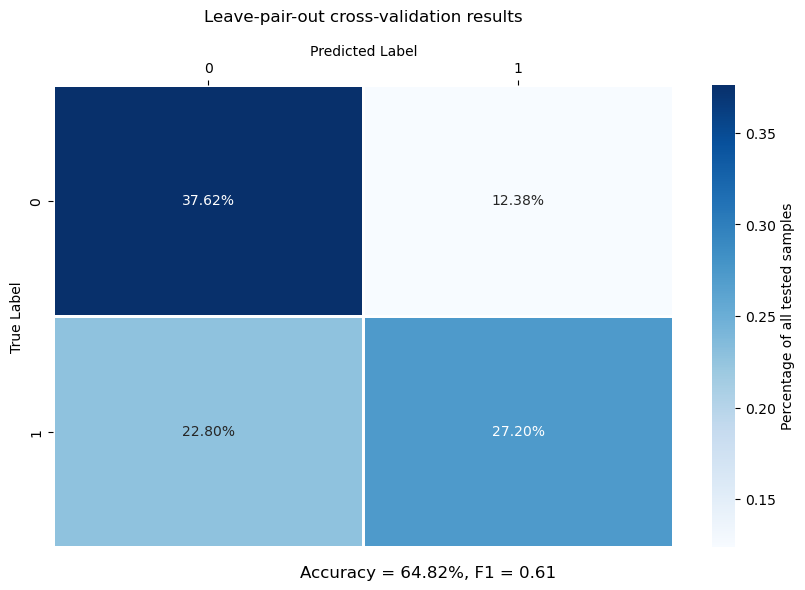

In [17]:
labels = list(labels_encoding_binary.keys())

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions, normalize='all')

title = f'Leave-pair-out cross-validation results'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'
filename = f'LPOCV_results.png'

plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir, filename))

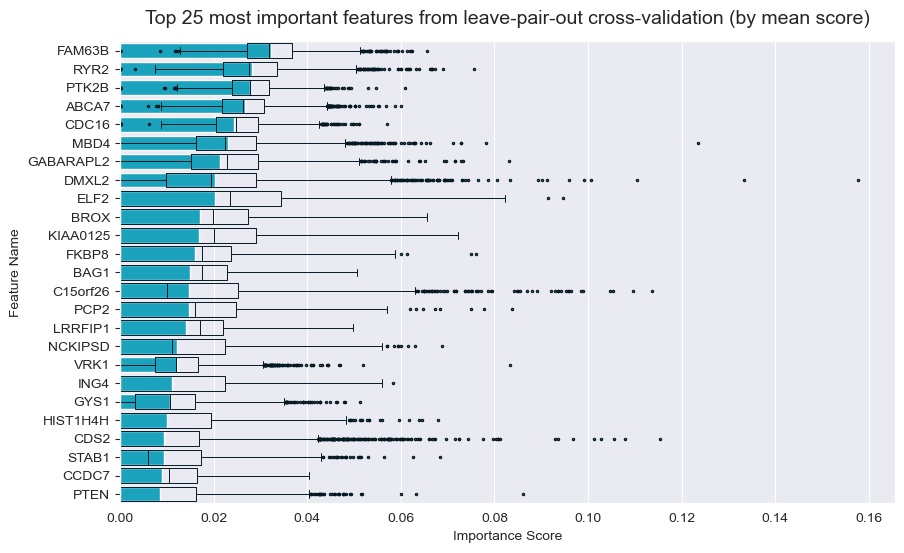

In [18]:
top_n = 25
filename = f'top_{top_n}_most_important_features.png'

plot_feature_importances(feature_importances_history, X.columns.to_numpy(), top_n=top_n, output_path=os.path.join(output_dir, filename))